<span style="color:Blue">

Introduction aux CNN - Jour 3
=============================

</span>

Datasets de [kaggle](https://www.kaggle.com/datasets) :

* ~~Car Damage Severity Dataset~~

* ~~The Drug Name Detection Dataset~~

* Flowers Datasets (dandelion & daisy)

<span style="color:Blue">

## 1 Importation des donnéees 'Flowers'

</span>

In [5]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from keras.utils import to_categorical
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [6]:
print('Contain of the folder: ', os.listdir("../flowers/"))

Contain of the folder:  ['README.dataset.txt', 'README.roboflow.txt', 'test', 'valid', 'train', 'desktop.ini']


In [7]:
data_dir = Path("../flowers/")
train_dir = data_dir/'train'
val_dir = data_dir/'valid'
test_dir = data_dir/'test'

In [8]:
def load_train():
    """
    Loads x train dataset to have an overview of the data.
    """
    daisy_dir = train_dir/'daisy'
    dandelion_dir = train_dir/'dandelion'
    daisy_flowers = daisy_dir.glob('*.jpg')
    dandelion_flowers = dandelion_dir.glob('*.jpg')
    train_data = []
    train_label = []
    for img in daisy_flowers:
        train_data.append(img)
        train_label.append('DAISY')
    for img in dandelion_flowers:
        train_data.append(img)
        train_label.append('DANDELION')
    df = pd.DataFrame(train_data)
    df.columns = ['images']
    df['labels'] = train_label
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [9]:
train_data = load_train()
print('Shape of loaded dataset: ', train_data.shape)

Shape of loaded dataset:  (1275, 2)


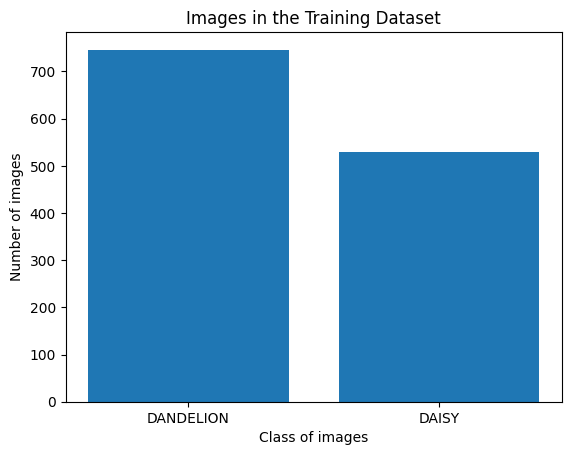

In [13]:
plt.bar(train_data['labels'].value_counts().index,
        train_data['labels'].value_counts().values)
plt.xlabel('Class of images')
plt.ylabel('Number of images')
plt.title('Images in the Training Dataset')
plt.show()

In [174]:
def plot_image(image_batch, label_batch):
    """
    Plots a set of images
    """
    plt.figure(figsize=(10,5))
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        img = cv2.imread(str(image_batch[i]), cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, (224,224))
        plt.imshow(img)
        plt.title(label_batch[i])
        plt.axis("off")

from tensorflow import io
from tensorflow import image
def plot_image2(image_batch, label_batch):
    """
    Plots a set of images with display function
    """
    plt.figure(figsize=(10,5))
    for i in range(10):
        #img = load_img(str(image_batch[i]),color_mode='rgb', target_size=(224, 224))
        #display(img)
        ax = plt.subplot(2,5,i+1)
        img = io.read_file(str(image_batch[i]))
        img = image.decode_png(img, channels=3)
        plt.imshow(img)
        plt.title(label_batch[i])
        plt.axis("off")

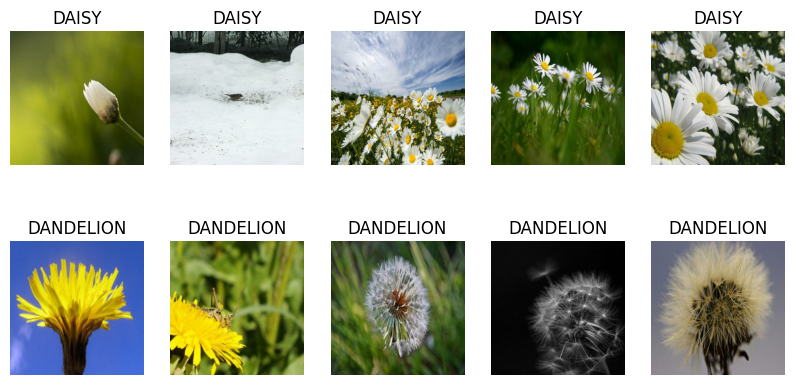

In [176]:
# Selected daisy flowers
daisy_dir = train_dir/'daisy'
image_batch = []
for i in range(5):
    file = random.choice(os.listdir(daisy_dir))
    file = str(daisy_dir) + chr(92) + str(file)
    image_batch.append(file)
label_batch = []
label_batch = ['DAISY']*5

# Selected dandelion flowers
dandelion_dir = train_dir/'dandelion'
for i in range(5):
    file = random.choice(os.listdir(dandelion_dir))
    file = str(dandelion_dir) + chr(92) + str(file)
    image_batch.append(file)
label_batch.extend(['DANDELION']*5)

# Plot
plot_image2(image_batch, label_batch)

In [59]:
def prepare_and_load(isval):
    """
    Loads training, validation or test dataset.
    """

    if isval == 'val':
        daisy_dir = val_dir/'daisy'
        dandelion_dir = val_dir/'dandelion'
    elif isval == 'test':
        daisy_dir = test_dir/'daisy'
        dandelion_dir = test_dir/'dandelion'
    else:
        daisy_dir = train_dir/'daisy'
        dandelion_dir = train_dir/'dandelion'
    daisy_flowers = daisy_dir.glob('*.jpg')
    dandelion_flowers = dandelion_dir.glob('*.jpg')
    data, labels = ([] for x in range(2))
    
    def prepare(case):
        for img in case:
            img = cv2.imread(str(img))
            img = cv2.resize(img, (224,224))
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            if case == daisy_flowers:
                label = to_categorical(0, num_classes=2)
            else:
                label = to_categorical(1, num_classes=2)
            data.append(img)
            labels.append(label)
        return data, labels
    
    prepare(daisy_flowers)
    d, l = prepare(dandelion_flowers)
    d = np.array(d)
    l = np.array(l)
    
    return d, l

In [60]:
x_train, y_train = prepare_and_load('train')
print('Number of training images -->', len(x_train))
print("Shape of x, y training set =", x_train.shape, y_train.shape)

x_val, y_val = prepare_and_load('val')
print('Number of validation images -->', len(x_val))
print("Shape of x, y validation set =", x_val.shape, y_val.shape)

x_test, y_test = prepare_and_load('test')
print('Number of test images -->', len(x_val))
print("Shape of x, y test set =", x_test.shape, y_test.shape)

Number of training images --> 1275
Shape of x, y training set = (1275, 224, 224, 3) (1275, 2)
Number of validation images --> 364
Shape of x, y validation set = (364, 224, 224, 3) (364, 2)
Number of test images --> 364
Shape of x, y test set = (182, 224, 224, 3) (182, 2)


<span style="color:Blue">

## 2 CNN

</span>

In [65]:
model0 = Sequential()
model0.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(224,224, 3))) 
model0.add(MaxPooling2D(pool_size=2))
model0.add(Flatten())
model0.add(Dense(2, activation='softmax'))
model0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      832       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 802816)            0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1605634   
                                                                 
Total params: 1606466 (6.13 MB)
Trainable params: 1606466 (6.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
model0.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10


40/40 [==============================] - 36s 849ms/step - loss: 8.9589 - accuracy: 0.5686 - val_loss: 1.3385 - val_accuracy: 0.6209
Epoch 2/10
40/40 [==============================] - 35s 881ms/step - loss: 0.7611 - accuracy: 0.6612 - val_loss: 0.6668 - val_accuracy: 0.6648
Epoch 3/10
40/40 [==============================] - 42s 1s/step - loss: 0.4182 - accuracy: 0.8180 - val_loss: 0.6847 - val_accuracy: 0.6676
Epoch 4/10
40/40 [==============================] - 37s 928ms/step - loss: 0.2765 - accuracy: 0.9082 - val_loss: 0.7495 - val_accuracy: 0.6676
Epoch 5/10
40/40 [==============================] - 31s 781ms/step - loss: 0.1827 - accuracy: 0.9427 - val_loss: 0.7332 - val_accuracy: 0.7033
Epoch 6/10
40/40 [==============================] - 30s 759ms/step - loss: 0.1238 - accuracy: 0.9741 - val_loss: 0.7578 - val_accuracy: 0.6648
Epoch 7/10
40/40 [==============================] - 30s 747ms/step - loss: 0.0742 - accuracy: 0.9898 - val_loss: 0.9268 - val_accuracy: 0.6758


In [67]:
_, test_acc0 = model0.evaluate(x_test, y_test)
print(test_acc0)

6/6 [==============================] - 1s 184ms/step - loss: 0.7716 - accuracy: 0.6978
0.6978021860122681


In [70]:
nets = 6
gsmodel = [0] *nets
for j in range(6):
    gsmodel[j] = Sequential()
    gsmodel[j].add(Conv2D(j*8+8, kernel_size=5, padding='same', activation='relu',input_shape=(224,224,3)))
    gsmodel[j].add(MaxPooling2D(pool_size=2))
    gsmodel[j].add(Flatten())
    gsmodel[j].add(Dense(20, activation='relu'))
    gsmodel[j].add(Dense(2, activation='softmax'))
    gsmodel[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [71]:
nets = 6
gshistory = [0] *nets
for j in range(6):
    gshistory[j] = gsmodel[j].fit(x_train, y_train, 
                                  epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
40/40 [==============================] - 8s 167ms/step - loss: 1.2428 - accuracy: 0.5749 - val_loss: 0.6915 - val_accuracy: 0.5522
Epoch 2/10
40/40 [==============================] - 5s 117ms/step - loss: 0.6893 - accuracy: 0.5851 - val_loss: 0.6899 - val_accuracy: 0.5522
Epoch 3/10
40/40 [==============================] - 5s 114ms/step - loss: 0.6863 - accuracy: 0.5851 - val_loss: 0.6835 - val_accuracy: 0.5522
Epoch 4/10
40/40 [==============================] - 5s 116ms/step - loss: 0.6660 - accuracy: 0.5851 - val_loss: 0.6392 - val_accuracy: 0.5549
Epoch 5/10
40/40 [==============================] - 5s 117ms/step - loss: 0.6096 - accuracy: 0.5835 - val_loss: 0.6334 - val_accuracy: 0.5522
Epoch 6/10
40/40 [==============================] - 5s 125ms/step - loss: 0.5573 - accuracy: 0.5890 - val_loss: 0.6447 - val_accuracy: 0.5522
Epoch 7/10
40/40 [==============================] - 5s 137ms/step - loss: 0.4895 - accuracy: 0.6361 - val_loss: 0.6543 - val_accuracy: 0.6868
Epoch 

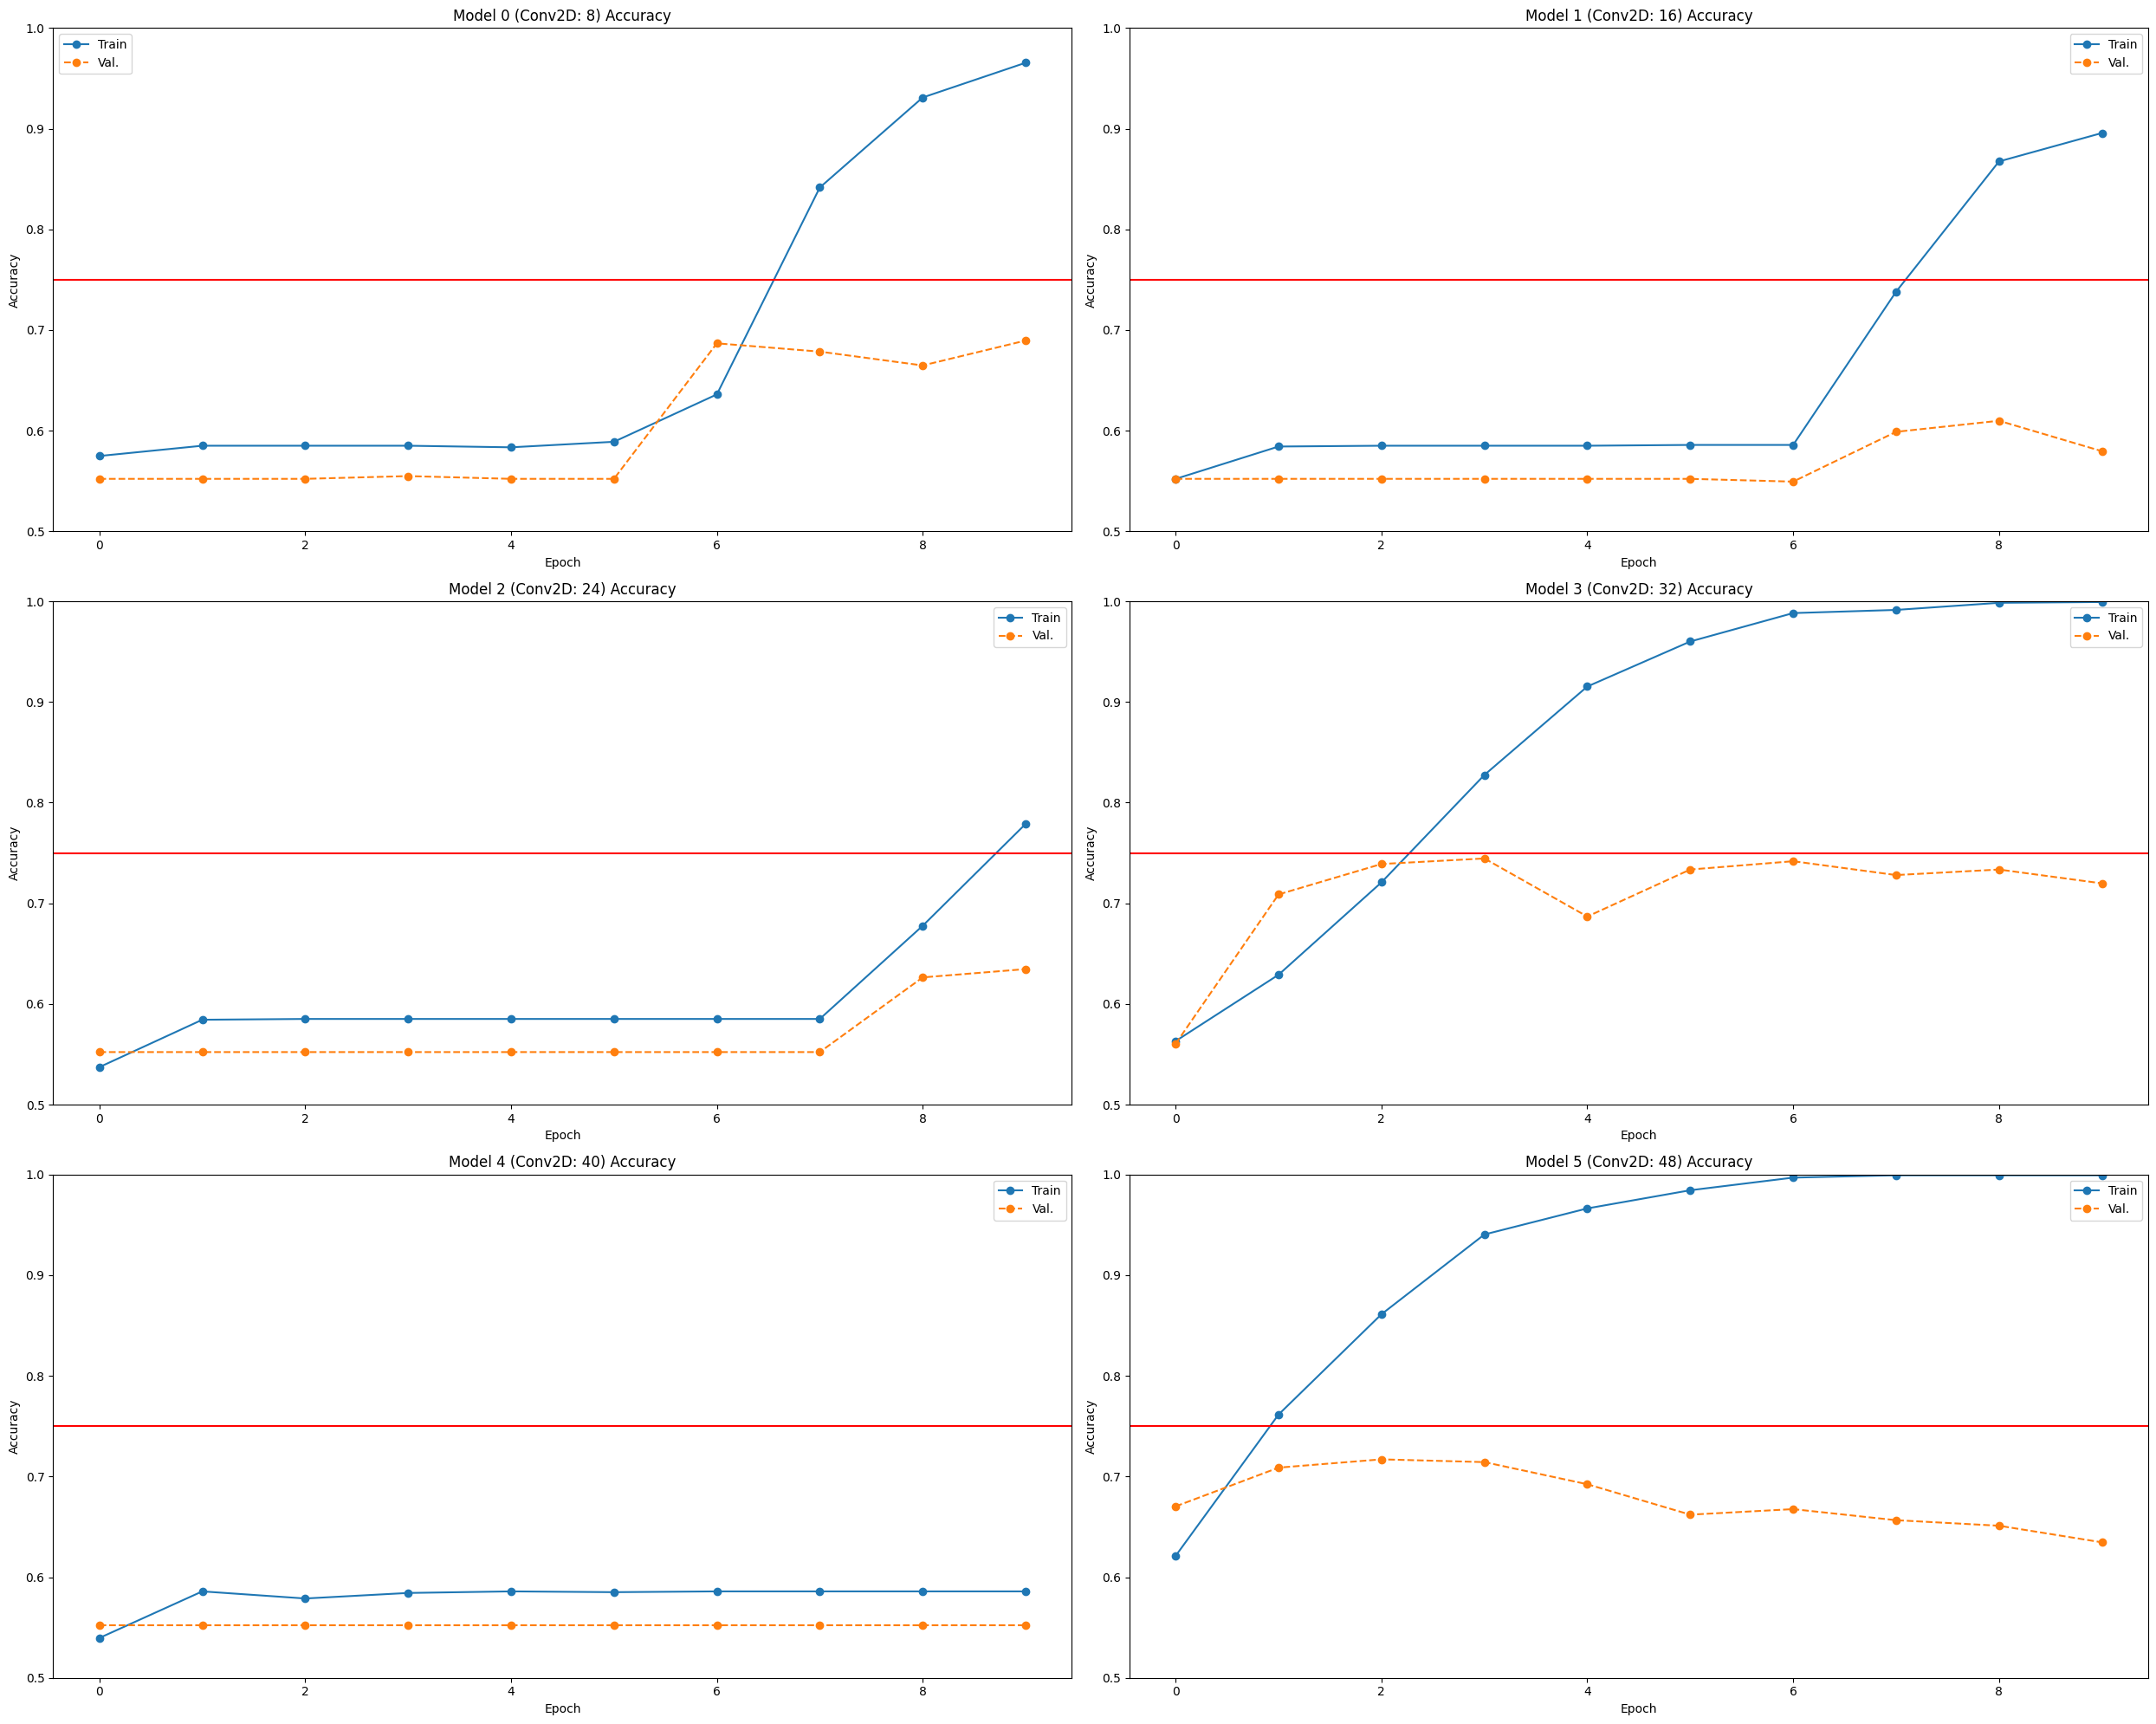

In [89]:
fig, axs = plt.subplots(3, 2, figsize=(25,20))
all_axs = axs.ravel()

for j in range(6):
   no = j*8+8
   ax = plt.subplot(3, 2, j + 1)
   ax.plot(gshistory[j].history['accuracy'], marker='o', label='Train')
   ax.plot(gshistory[j].history['val_accuracy'], marker='o', linestyle='dashed', label='Val.')
   ax.axhline(y = 0.75, color = 'r', linestyle = '-')
   ax.set_ylim([0.5, 1])
   ax.set_xlabel('Epoch')
   ax.set_ylabel('Accuracy')
   ax.set_title(f'Model {j} (Conv2D: {no}) Accuracy')
   ax.legend()
fig.tight_layout()

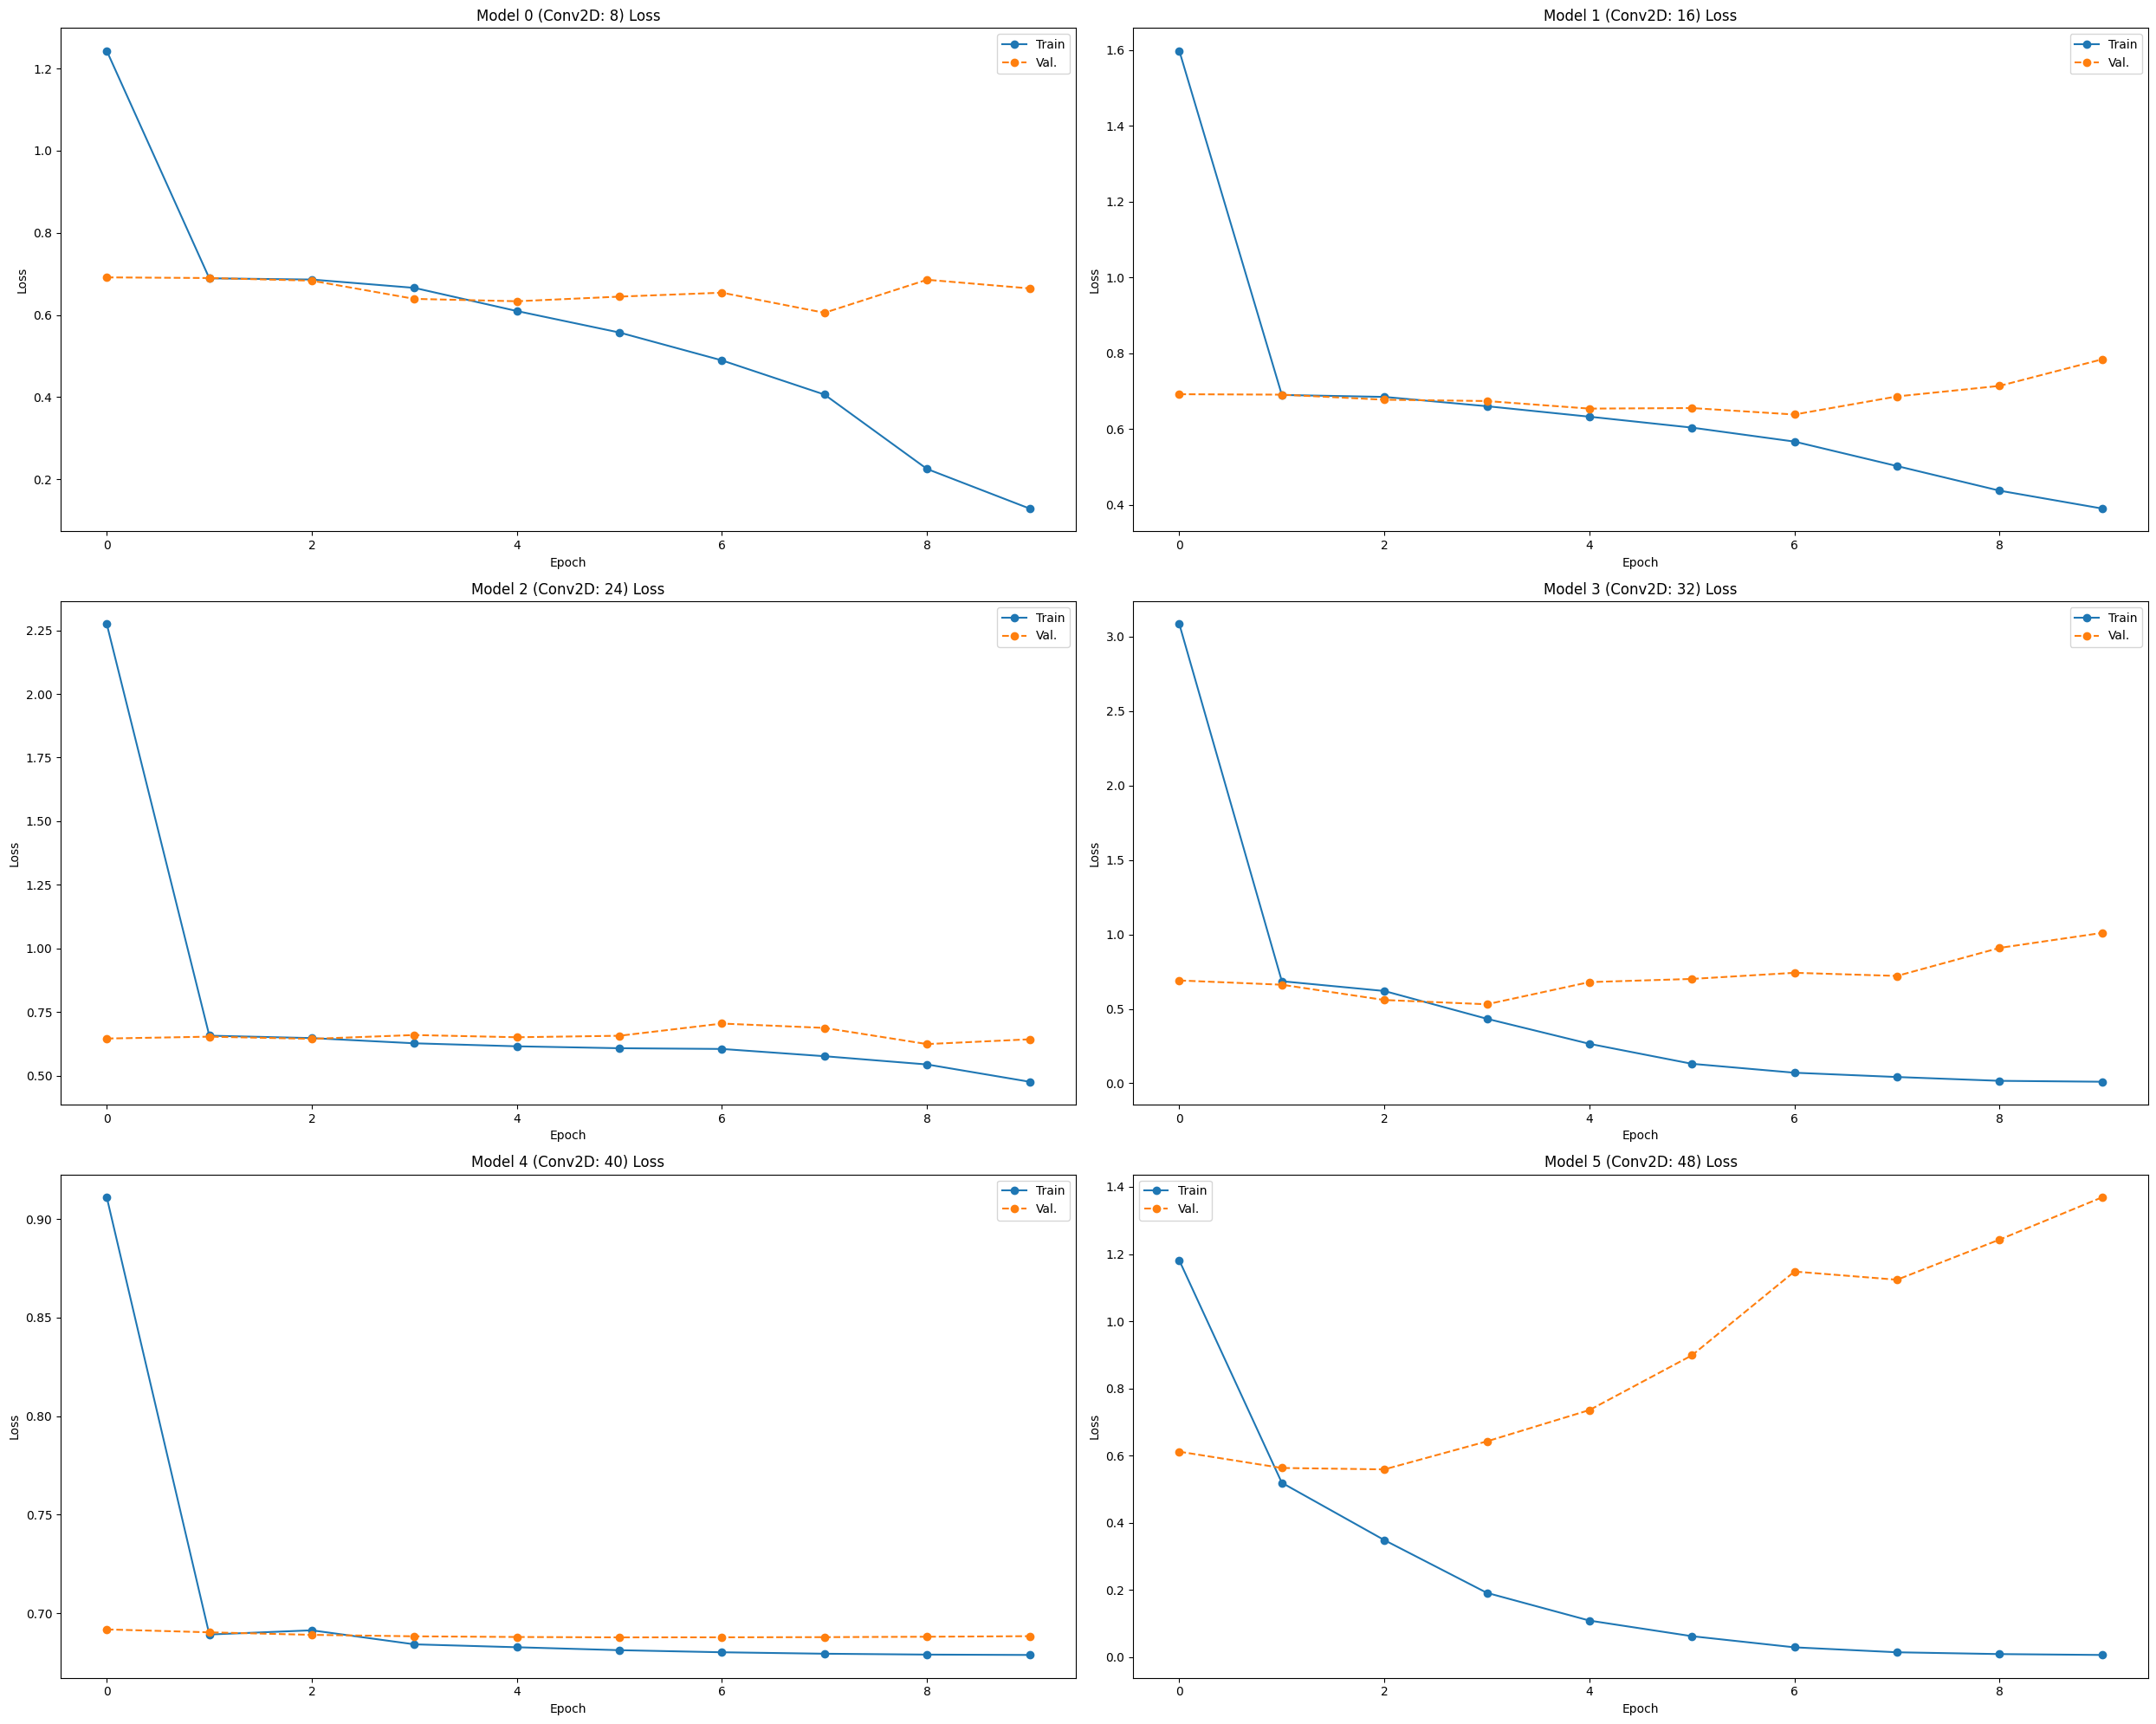

In [90]:
fig, axs = plt.subplots(3, 2, figsize=(25,20))
all_axs = axs.ravel()

for j in range(6):
   no = j*8+8
   ax = plt.subplot(3, 2, j + 1)
   ax.plot(gshistory[j].history['loss'], marker='o', label='Train')
   ax.plot(gshistory[j].history['val_loss'], marker='o', linestyle='dashed', label='Val.')
   #ax.axhline(y = 0.75, color = 'r', linestyle = '-')
   #ax.set_ylim([0.5, 1])
   ax.set_xlabel('Epoch')
   ax.set_ylabel('Loss')
   ax.set_title(f'Model {j} (Conv2D: {no}) Loss')
   ax.legend()
fig.tight_layout()

<span style="color:Blue">

## 3 Modèle VGG-16 pré-entrainé

</span>

In [91]:
from keras.applications.vgg16 import VGG16

model1 = VGG16() # Création du modèle VGG-16 implementé par Keras

553467096/553467096 [==============================] - 1430s 3us/step


Classification of selected images using categories from [ImageNet](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

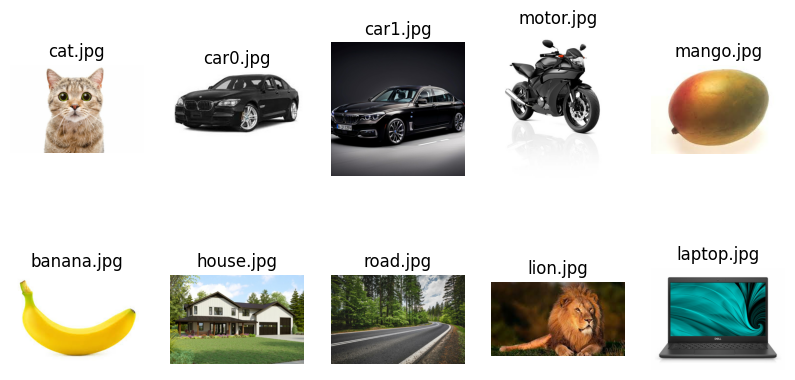

In [177]:
import pathlib
test_images_dir = Path('../images_test/')
image_batch = list(test_images_dir.glob('**/*.jpg'))
#image_batch = test_images_dir.glob('*.jpg')
label_batch = os.listdir(test_images_dir)
#plot_image(image_batch, label_batch)
plot_image2(image_batch, label_batch)

In [181]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

def image_class(model, the_image):
    """
    Gives classification of an image by a model.
    """
    img = load_img(the_image, color_mode='rgb', target_size=(224, 224))  # Charger l'image
    img = img_to_array(img)  # Convertir en tableau numpy
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
    img = preprocess_input(img)  # Prétraiter l'image comme le veut le modèle
    
    return model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

In [182]:
nets = 10
pimage = [0] *nets
no = 0           
for image in test_images_dir.glob('*.jpg'):
    pimage[no] = image_class(model1, image)
    no += 1

1/1 [==============================] - 0s 413ms/step


In [183]:
no = 0
for image in test_images_dir.glob('*.jpg'):    
    # Afficher les 3 classes les plus probables
    classes = decode_predictions(pimage[no], top=3)[0]
    print('\n', image, ': Top 3 classes --->', classes)
    no += 1


 ..\images_test\cat.jpg : Top 3 classes ---> [('n02124075', 'Egyptian_cat', 0.4866619), ('n02123045', 'tabby', 0.35436285), ('n02123159', 'tiger_cat', 0.11015695)]

 ..\images_test\car0.jpg : Top 3 classes ---> [('n03100240', 'convertible', 0.20985536), ('n04285008', 'sports_car', 0.17892931), ('n04037443', 'racer', 0.11341681)]

 ..\images_test\car1.jpg : Top 3 classes ---> [('n02814533', 'beach_wagon', 0.41668734), ('n03100240', 'convertible', 0.17810918), ('n02974003', 'car_wheel', 0.12207514)]

 ..\images_test\motor.jpg : Top 3 classes ---> [('n03791053', 'motor_scooter', 0.37865844), ('n04252077', 'snowmobile', 0.28056896), ('n03127747', 'crash_helmet', 0.21119295)]

 ..\images_test\mango.jpg : Top 3 classes ---> [('n12267677', 'acorn', 0.42007032), ('n03134739', 'croquet_ball', 0.26532847), ('n03720891', 'maraca', 0.11242549)]

 ..\images_test\banana.jpg : Top 3 classes ---> [('n07753592', 'banana', 0.73949236), ('n07749582', 'lemon', 0.10824229), ('n04579432', 'whistle', 0.0351

<span style="color:Blue">

## 4 Modèles MobileNetV2 et InceptionV3 pré-entrainés

</span>

<span style="color:Blue">

### 4.1 Modèle MobileNetV2

</span>

In [184]:
from keras.applications.mobilenet_v2 import MobileNetV2

model_mobilenet = MobileNetV2(weights='imagenet')

14536120/14536120 [==============================] - 38s 3us/step


In [185]:
nets = 10
pimage = [0] *nets
no = 0          
for image in test_images_dir.glob('*.jpg'):
    pimage[no] = image_class(model_mobilenet, image)
    no += 1

1/1 [==============================] - 0s 108ms/step


In [186]:
no = 0
for image in test_images_dir.glob('*.jpg'):    
    # Afficher les 3 classes les plus probables
    classes = decode_predictions(pimage[no], top=3)[0]
    print('\n', image, ': Top 3 classes --->', classes)
    no += 1


 ..\images_test\cat.jpg : Top 3 classes ---> [('n04589890', 'window_screen', 0.20253292), ('n04399382', 'teddy', 0.13652785), ('n04074963', 'remote_control', 0.04502444)]

 ..\images_test\car0.jpg : Top 3 classes ---> [('n03709823', 'mailbag', 0.20140216), ('n04074963', 'remote_control', 0.08901483), ('n02667093', 'abaya', 0.041564178)]

 ..\images_test\car1.jpg : Top 3 classes ---> [('n04418357', 'theater_curtain', 0.15093635), ('n04037443', 'racer', 0.10097416), ('n02974003', 'car_wheel', 0.09550317)]

 ..\images_test\motor.jpg : Top 3 classes ---> [('n03874599', 'padlock', 0.10824948), ('n02841315', 'binoculars', 0.06063599), ('n03627232', 'knot', 0.048478156)]

 ..\images_test\mango.jpg : Top 3 classes ---> [('n02782093', 'balloon', 0.6127225), ('n03127747', 'crash_helmet', 0.043496225), ('n04023962', 'punching_bag', 0.015700443)]

 ..\images_test\banana.jpg : Top 3 classes ---> [('n02892767', 'brassiere', 0.18799599), ('n02834397', 'bib', 0.17279275), ('n03532672', 'hook', 0.0725

<span style="color:Blue">

### 4.2 Modèle InceptionV3

</span>

In [187]:
from keras.applications.inception_v3 import InceptionV3

model_inception = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 266s 3us/step


In [189]:
def image_class_inception(model, the_image):
    """
    Gives classification of an image by a model.
    """
    img = load_img(the_image, color_mode='rgb', target_size=(299, 299))  # Charger l'image
    img = img_to_array(img)  # Convertir en tableau numpy
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
    img = preprocess_input(img)  # Prétraiter l'image comme le veut le modèle
    
    return model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

In [190]:
nets = 10
pimage = [0] *nets
no = 0
for image in test_images_dir.glob('*.jpg'):
    pimage[no] = image_class_inception(model_inception, image)
    no += 1

1/1 [==============================] - 0s 117ms/step


In [191]:
no = 0
for image in test_images_dir.glob('*.jpg'):    
    # Afficher les 3 classes les plus probables
    classes = decode_predictions(pimage[no], top=3)[0]
    print('\n', image, ': Top 3 classes --->', classes)
    no += 1


 ..\images_test\cat.jpg : Top 3 classes ---> [('n04099969', 'rocking_chair', 0.90997034), ('n04317175', 'stethoscope', 0.0900127), ('n03775546', 'mixing_bowl', 1.6413214e-05)]

 ..\images_test\car0.jpg : Top 3 classes ---> [('n01924916', 'flatworm', 1.0), ('n03481172', 'hammer', 2.6394266e-08), ('n06359193', 'web_site', 3.9503355e-11)]

 ..\images_test\car1.jpg : Top 3 classes ---> [('n06359193', 'web_site', 1.0), ('n15075141', 'toilet_tissue', 0.0), ('n02319095', 'sea_urchin', 0.0)]

 ..\images_test\motor.jpg : Top 3 classes ---> [('n06359193', 'web_site', 0.99920493), ('n03950228', 'pitcher', 0.0005217545), ('n04131690', 'saltshaker', 0.00013349661)]

 ..\images_test\mango.jpg : Top 3 classes ---> [('n06359193', 'web_site', 0.99881893), ('n04286575', 'spotlight', 0.0011809915), ('n03950228', 'pitcher', 5.2410073e-08)]

 ..\images_test\banana.jpg : Top 3 classes ---> [('n03047690', 'clog', 0.9860428), ('n06359193', 'web_site', 0.013957285), ('n02841315', 'binoculars', 1.98007e-11)]



<span style="color:Blue">

## 5 Transfer Learning avec le modèle VGG-16

</span>

In [192]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model_vgg1 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 153s 3us/step


In [197]:
# Function for use transfert learning
def create_model(model, strategy=0):
    """
    model: VGG16 model
    strategy: 
        1 total fine-tuning (default)
        2 for feature extraction
        3 for partial fine-tuning
    """

    # total fine-tuning: train all the network
    if strategy == 1:
        for layer in model.layers:
            layer.trainable = True

    # feature extraction: train only new classifier
    elif strategy == 2:
        for layer in model.layers:
            layer.trainable = False

    # partial fine-tuning: do not train the first 5 layers
    elif strategy == 3:
        for layer in model.layers[:5]:
           layer.trainable = False
        
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = model.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(200, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(2, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

<span style="color:Blue">

### 5.1 Stratégie 1 : *fine-tuning* total
</span>

In [198]:
# Entrainer tout le réseau
model1_fromvgg1 = create_model(model_vgg1, strategy=1)

In [199]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model1_fromvgg1_info = model1_fromvgg1.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
40/40 [==============================] - 1317s 33s/step - loss: 8.1753 - accuracy: 0.5271 - val_loss: 1.5127 - val_accuracy: 0.5522
Epoch 2/10
40/40 [==============================] - 1227s 31s/step - loss: 0.6883 - accuracy: 0.5663 - val_loss: 0.6790 - val_accuracy: 0.5522
Epoch 3/10
40/40 [==============================] - 1192s 30s/step - loss: 0.6800 - accuracy: 0.5851 - val_loss: 0.6779 - val_accuracy: 0.5769
Epoch 4/10
40/40 [==============================] - 1219s 30s/step - loss: 0.6509 - accuracy: 0.6235 - val_loss: 0.5981 - val_accuracy: 0.7500
Epoch 5/10
40/40 [==============================] - 1249s 31s/step - loss: 0.7295 - accuracy: 0.5843 - val_loss: 0.6928 - val_accuracy: 0.5522
Epoch 6/10
40/40 [==============================] - 1240s 31s/step - loss: 0.7458 - accuracy: 0.5733 - val_loss: 0.6950 - val_accuracy: 0.4478
Epoch 7/10
40/40 [==============================] - 1236s 31s/step - loss: 0.6855 - accuracy: 0.5780 - val_loss: 0.6919 - val_accuracy: 0.5522

In [200]:
_, test_acc1_fromvgg1 = model1_fromvgg1.evaluate(x_test, y_test)

6/6 [==============================] - 34s 6s/step - loss: 0.6813 - accuracy: 0.5769


<span style="color:Blue">

### 5.2 Stratégie 2 : extraction de features

</span>

In [201]:
# Entrainer seulement le nouveau classifieur
model2_fromvgg1 = create_model(model_vgg1, strategy=2)

In [202]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model2_fromvgg1_info = model2_fromvgg1.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
40/40 [==============================] - 300s 7s/step - loss: 0.6914 - accuracy: 0.5804 - val_loss: 0.6907 - val_accuracy: 0.5522
Epoch 2/10
40/40 [==============================] - 278s 7s/step - loss: 0.6876 - accuracy: 0.5851 - val_loss: 0.6892 - val_accuracy: 0.5522
Epoch 3/10
40/40 [==============================] - 278s 7s/step - loss: 0.6849 - accuracy: 0.5851 - val_loss: 0.6883 - val_accuracy: 0.5522
Epoch 4/10
40/40 [==============================] - 280s 7s/step - loss: 0.6829 - accuracy: 0.5851 - val_loss: 0.6879 - val_accuracy: 0.5522
Epoch 5/10
40/40 [==============================] - 278s 7s/step - loss: 0.6815 - accuracy: 0.5851 - val_loss: 0.6877 - val_accuracy: 0.5522
Epoch 6/10
40/40 [==============================] - 278s 7s/step - loss: 0.6806 - accuracy: 0.5851 - val_loss: 0.6877 - val_accuracy: 0.5522
Epoch 7/10
40/40 [==============================] - 284s 7s/step - loss: 0.6799 - accuracy: 0.5851 - val_loss: 0.6879 - val_accuracy: 0.5522
Epoch 8/10
40

In [203]:
_, test_acc2_fromvgg1 = model2_fromvgg1.evaluate(x_test, y_test)

6/6 [==============================] - 26s 4s/step - loss: 0.6813 - accuracy: 0.5769


<span style="color:Blue">

### 5.3 Stratégie 3 : *fine-tuning* partiel

</span>

In [204]:
# Ne pas entrainer les 5 premières couches (les plus basses)
model3_fromvgg1 = create_model(model_vgg1, strategy=3)

In [205]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model3_fromvgg1_info = model3_fromvgg1.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
40/40 [==============================] - 338s 8s/step - loss: 0.6911 - accuracy: 0.5757 - val_loss: 0.6908 - val_accuracy: 0.5522
Epoch 2/10
40/40 [==============================] - 293s 7s/step - loss: 0.6876 - accuracy: 0.5851 - val_loss: 0.6892 - val_accuracy: 0.5522
Epoch 3/10
40/40 [==============================] - 282s 7s/step - loss: 0.6849 - accuracy: 0.5851 - val_loss: 0.6883 - val_accuracy: 0.5522
Epoch 4/10
40/40 [==============================] - 287s 7s/step - loss: 0.6831 - accuracy: 0.5851 - val_loss: 0.6879 - val_accuracy: 0.5522
Epoch 5/10
40/40 [==============================] - 290s 7s/step - loss: 0.6817 - accuracy: 0.5851 - val_loss: 0.6877 - val_accuracy: 0.5522
Epoch 6/10
40/40 [==============================] - 281s 7s/step - loss: 0.6807 - accuracy: 0.5851 - val_loss: 0.6877 - val_accuracy: 0.5522
Epoch 7/10
40/40 [==============================] - 281s 7s/step - loss: 0.6800 - accuracy: 0.5851 - val_loss: 0.6879 - val_accuracy: 0.5522
Epoch 8/10
40

In [206]:
_, test_acc3_fromvgg1 = model3_fromvgg1.evaluate(x_test, y_test)

6/6 [==============================] - 34s 6s/step - loss: 0.6813 - accuracy: 0.5769


<span style="color:Blue">

### 5.4 Comparaison

</span>

In [207]:
print('Models accuracy \n')
print(' Initial CNN:', test_acc0)
print(' Total Fine-tuning:', test_acc1_fromvgg1)
print(' Feature extraction:', test_acc2_fromvgg1)
print(' Partial fine-tuning:', test_acc3_fromvgg1)

Models accuracy 

 Initial CNN: 0.6978021860122681
 Total Fine-tuning: 0.5769230723381042
 Feature extraction: 0.5769230723381042
 Partial fine-tuning: 0.5769230723381042


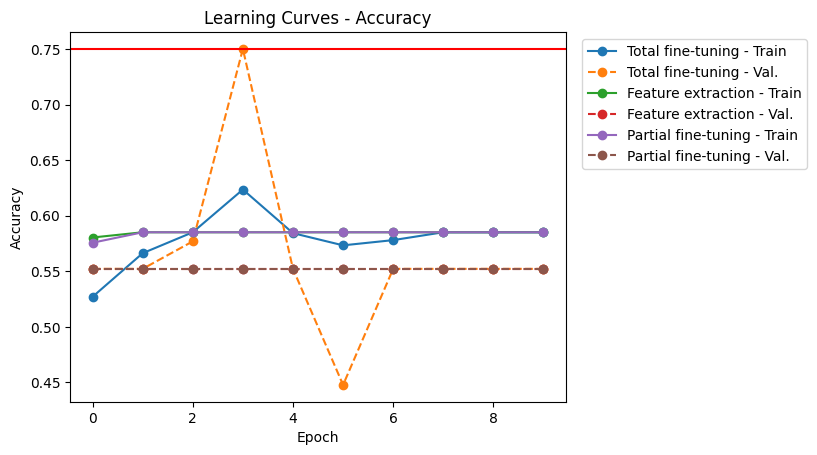

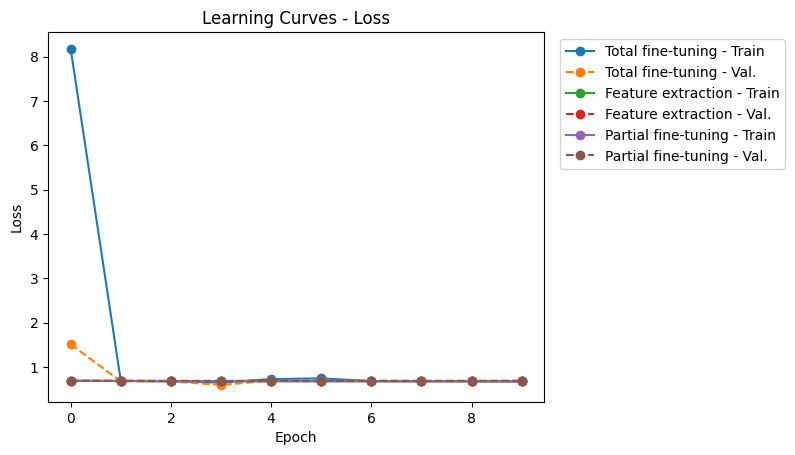

In [214]:
models = [model1_fromvgg1_info, model2_fromvgg1_info, model3_fromvgg1_info]

plt.title('Learning Curves - Accuracy')
plt.plot(model1_fromvgg1_info.history['accuracy'],  marker='o', label='Total fine-tuning - Train')
plt.plot(model1_fromvgg1_info.history['val_accuracy'], marker='o', linestyle='dashed', label='Total fine-tuning - Val.')
plt.plot(model2_fromvgg1_info.history['accuracy'],  marker='o', label='Feature extraction - Train')
plt.plot(model2_fromvgg1_info.history['val_accuracy'], marker='o', linestyle='dashed', label='Feature extraction - Val.')
plt.plot(model3_fromvgg1_info.history['accuracy'],  marker='o', label='Partial fine-tuning - Train')
plt.plot(model3_fromvgg1_info.history['val_accuracy'], marker='o', linestyle='dashed', label='Partial fine-tuning - Val.')
plt.axhline(y = 0.75, color = 'r', linestyle = '-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0))
plt.show()

plt.title('Learning Curves - Loss')
plt.plot(model1_fromvgg1_info.history['loss'],  marker='o', label='Total fine-tuning - Train')
plt.plot(model1_fromvgg1_info.history['val_loss'], marker='o', linestyle='dashed', label='Total fine-tuning - Val.')
plt.plot(model2_fromvgg1_info.history['loss'],  marker='o', label='Feature extraction - Train')
plt.plot(model2_fromvgg1_info.history['val_loss'], marker='o', linestyle='dashed', label='Feature extraction - Val.')
plt.plot(model3_fromvgg1_info.history['loss'],  marker='o', label='Partial fine-tuning - Train')
plt.plot(model3_fromvgg1_info.history['val_loss'], marker='o', linestyle='dashed', label='Partial fine-tuning - Val.')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0))
plt.show()

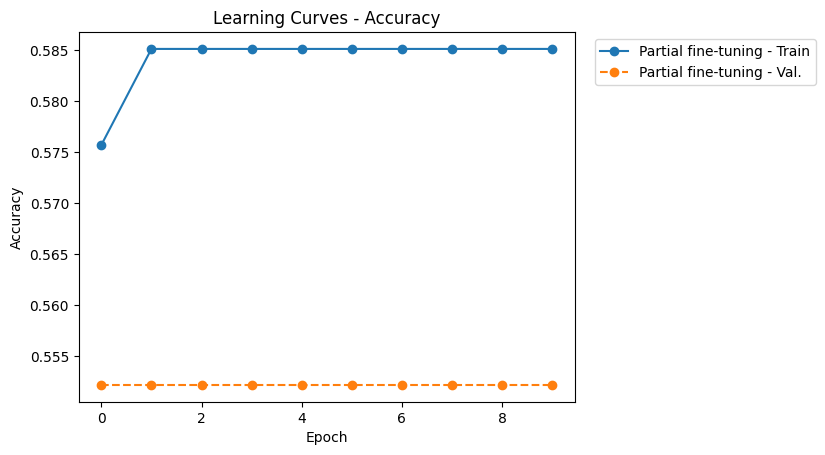

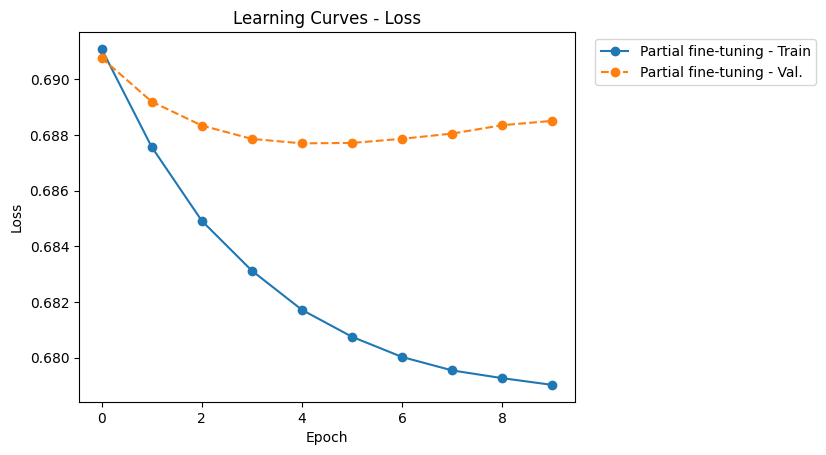

In [219]:
models = [model1_fromvgg1_info, model2_fromvgg1_info, model3_fromvgg1_info]

plt.title('Learning Curves - Accuracy')
plt.plot(model3_fromvgg1_info.history['accuracy'],  marker='o', label='Partial fine-tuning - Train')
plt.plot(model3_fromvgg1_info.history['val_accuracy'], marker='o', linestyle='dashed', label='Partial fine-tuning - Val.')
#plt.axhline(y = 0.75, color = 'r', linestyle = '-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0))
plt.show()

plt.title('Learning Curves - Loss')
plt.plot(model3_fromvgg1_info.history['loss'],  marker='o', label='Partial fine-tuning - Train')
plt.plot(model3_fromvgg1_info.history['val_loss'], marker='o', linestyle='dashed', label='Partial fine-tuning - Val.')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0))
plt.show()